In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import random
import carla
import time

In [2]:
client = carla.Client('localhost', 2000)
client.set_timeout(10.0)
world = client.load_world('Town03')
town_map = world.get_map()
print(town_map)

Map(name=Town03)


In [3]:
blueprint_library = world.get_blueprint_library()
vehicle_bp = blueprint_library.filter("vehicle.audi.tt")[0]
map = world.get_map()
starting_point = map.get_spawn_points()[0]
vehicle = world.try_spawn_actor(vehicle_bp, starting_point)
vehicle_pos = vehicle.get_transform()
lidar_bp = world.get_blueprint_library().find("sensor.lidar.ray_cast")
lidar_bp.set_attribute('range', str(100))
lidar_bp.set_attribute('points_per_second', str(10000))
lidar_bp.set_attribute('rotation_frequency', str(10.0))
lidar_bp.set_attribute('upper_fov', str(30.0))
lidar_bp.set_attribute('lower_fov', str(-25.0))
lidar_bp.set_attribute('channels', str(32))
lidar_transform = carla.Transform(carla.Location(x = 0, z= 2.5))
lidar_sensor = world.spawn_actor(lidar_bp, lidar_transform, attach_to = vehicle)
print(vehicle_pos)
print("Intial start point:", starting_point)

Transform(Location(x=0.000000, y=0.000000, z=0.000000), Rotation(pitch=0.000000, yaw=0.000000, roll=0.000000))
Intial start point: Transform(Location(x=-6.446170, y=-79.055023, z=0.275307), Rotation(pitch=0.000000, yaw=92.004189, roll=0.000000))


In [4]:

spawn_points= map.get_spawn_points()
min_x, min_y, min_z = float('inf'), float('inf'), float('inf')
max_x, max_y, max_z = float('-inf'), float('-inf'), float('-inf')

# Find the boundary by checking each spawn point location
for spawn_point in spawn_points:
    location = spawn_point.location
    min_x, min_y, min_z = min(min_x, location.x), min(min_y, location.y), min(min_z, location.z)
    max_x, max_y, max_z = max(max_x, location.x), max(max_y, location.y), max(max_z, location.z)

# Define the map size as the difference between max and min coordinates
map_size_x = max_x - min_x
map_size_y = max_y - min_y
map_size_z = max_z - min_z


In [5]:
start_location = starting_point
goal_location = carla.Location(x = 200, y = 190.77,z = 0 )

In [6]:
# Node class representing a state in the space
class Node:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.parent = None
        self.cost = 0

# RRT* algorithm
class RRTStar:
    def __init__(self, start, goal, map_size, lidar_sensor, step_size=1.0, max_iter=500):
        self.start = Node(start.location.x,start.location.y , start.location.z)
        self.goal = Node(goal.x, goal.y, goal.z)
        self.map_size = map_size
        self.step_size = step_size
        self.max_iter = max_iter
        self.node_list = [self.start]
        self.goal_region_radius = 1.5
        self.search_radius = 2.0
        self.path = None
        self.goal_reached = False
        self.lidar_data = []
        self.lidar_sensor = lidar_sensor
        self.lidar_sensor.listen(self.get_lidar_data)
        # Visualization setup
        self.fig, self.ax = plt.subplots()
        self.setup_visualization()

    def get_lidar_data(self,lidar_data):
        self.lidar_data.clear()
        for detection in lidar_data: # Assuming lidar_data gives direct access to these properties
            distance = math.sqrt((detection.point.x**2) + (detection.point.y**2) + (detection.point.z**2))
            print("Distance:", distance)
            if distance < 4:
                print("the distance is lower than 4 m their are an obstecles ")
                self.lidar_data.append((x, y))       

    def setup_visualization(self):
        """Set up the visualization environment (grid, start, goal, obstacles)."""
        self.ax.plot(self.start.x, self.start.y, 'bo', label='Start')
        self.ax.plot(self.goal.x, self.goal.y, 'ro', label='Goal')
        self.ax.set_xlim(0, self.map_size[0])
        self.ax.set_ylim(0, self.map_size[1])
        self.ax.grid(True)
        
    def plan(self):
        """Main RRT* planning loop."""
        for i in range(self.max_iter):
            rand_node = self.get_random_node()
            nearest_node = self.get_nearest_node(self.node_list, rand_node)
            new_node = self.steer(nearest_node, rand_node)

            if self.is_collision_free(new_node):
                neighbors = self.find_neighbors(new_node)
                new_node = self.choose_parent(neighbors, nearest_node, new_node)
                self.node_list.append(new_node)
                self.rewire(new_node, neighbors)

            if self.reached_goal(new_node):
                self.path = self.generate_final_path(new_node)
                self.goal_reached = True
                return

    def get_random_node(self):
        """Generate a random node in the map."""
        if random.random() > 0.2:
            rand_node = Node(random.uniform(0, self.map_size[0]), random.uniform(0, self.map_size[1]), random.uniform(0, self.map_size[2]))
        else:
            rand_node = Node(self.goal.x, self.goal.y,self.goal.z)
        return rand_node

    def steer(self, from_node, to_node):
        """Steer from one node to another, step-by-step."""
        theta = math.atan2(to_node.y - from_node.y, to_node.x - from_node.x)
        new_node = Node(from_node.x + self.step_size * math.cos(theta),
                        from_node.y + self.step_size * math.sin(theta))
        new_node.cost = from_node.cost + self.step_size
        new_node.parent = from_node
        return new_node

    def is_collision_free(self, node):
        """Check if the node is collision-free with respect to obstacles."""
        for (ox, oy) in self.lidar_data:
            if (node.x - ox) ** 2 + (node.y - oy) ** 2 <= (2.0 ** 2):
                return False
        return True

    def find_neighbors(self, new_node):
        """Find nearby nodes within the search radius."""
        return [node for node in self.node_list
                if np.linalg.norm([node.x - new_node.x, node.y - new_node.y]) < self.search_radius]

    def choose_parent(self, neighbors, nearest_node, new_node):
        """Choose the best parent for the new node based on cost."""
        min_cost = nearest_node.cost + np.linalg.norm([new_node.x - nearest_node.x, new_node.y - nearest_node.y])
        best_node = nearest_node

        for neighbor in neighbors:
            cost = neighbor.cost + np.linalg.norm([new_node.x - neighbor.x, new_node.y - neighbor.y])
            if cost < min_cost and self.is_collision_free(neighbor):
                best_node = neighbor
                min_cost = cost

        new_node.cost = min_cost
        new_node.parent = best_node
        return new_node

    def rewire(self, new_node, neighbors):
        """Rewire the tree by checking if any neighbor should adopt the new node as a parent."""
        for neighbor in neighbors:
            cost = new_node.cost + np.linalg.norm([neighbor.x - new_node.x, neighbor.y - new_node.y])
            if cost < neighbor.cost and self.is_collision_free(neighbor):
                neighbor.parent = new_node
                neighbor.cost = cost

    def reached_goal(self, node):
        """Check if the goal has been reached."""
        return np.linalg.norm([node.x - self.goal.x, node.y - self.goal.y]) < self.goal_region_radius

    def generate_final_path(self, goal_node):
        """Generate the final path from the start to the goal and drive along it."""
        path = []
        node = goal_node
        while node is not None:
            path.append([node.x, node.y])
            node = node.parent
        path = path[::-1]  # Reverse path

        # Control loop for moving the vehicle along the path
        for waypoint in path:
            while True:
                vehicle_location = vehicle.get_location()
                distance = vehicle_location.distance(carla.Location(x=waypoint[0], y=waypoint[1]))

                if distance < 2.0:  # Threshold to move to the next waypoint
                    break

                control = carla.VehicleControl()
                control.throttle = min(0.5, distance / 10)

                # Calculate the steering angle
                angle_to_target = math.atan2(
                    waypoint[1] - vehicle_location.y,
                    waypoint[0] - vehicle_location.x
                )
                vehicle_yaw = math.radians(vehicle.get_transform().rotation.yaw)
                control.steer = max(-1.0, min(1.0, angle_to_target - vehicle_yaw))

                # Apply control to the vehicle
                vehicle.apply_control(control)
                
                # Small sleep to give time for control update
                time.sleep(0.1)
        
        return path  # Return the path for visualization purposes

    def get_nearest_node(self, node_list, rand_node):
        """Find the nearest node in the tree to the random node."""
        distances = [np.linalg.norm([node.x - rand_node.x, node.y - rand_node.y]) for node in node_list]
        nearest_node = node_list[np.argmin(distances)]
        return nearest_node

    def draw_tree(self, node):
        """Draw a tree edge from the current node to its parent."""
        if node.parent:
            self.ax.plot([node.x, node.parent.x], [node.y, node.parent.y], "-b")

    def draw_path(self):
        """Draw the final path from start to goal."""
        if self.path:
            self.ax.plot([x[0] for x in self.path], [x[1] for x in self.path], '-g', label='Path')

Distance: 5.514346386050025
Distance: 5.448822342197243
Distance: 5.337396818081766
Distance: 5.250184862253051
Distance: 5.160844700002291
Distance: 5.141510221618284
Distance: 99.67444230820026
Distance: 5.118719612779881
Distance: 98.60920844004418
Distance: 5.11602774625607
Distance: 98.5703542314688
Distance: 5.118231320803339
Distance: 73.67287204508253
Distance: 73.67286381683354
Distance: 69.18452203463517
Distance: 40.39694583367724
Distance: 38.8079308742161
Distance: 27.459773652382143
Distance: 26.01539595883978
Distance: 19.99378912662555
Distance: 5.154509729928205
Distance: 18.83458376414701
Distance: 18.488651611711305
Distance: 15.804331826483459
Distance: 5.176698997399535
Distance: 12.653940525710363
Distance: 12.467784002447315
Distance: 12.873680174681109
Distance: 11.053833238800804
Distance: 11.001707150493159
Distance: 10.72397821350673
Distance: 11.423673902490645
Distance: 9.581808717260547
Distance: 9.431299347814477
Distance: 10.036158120831468
Distance: 8.5

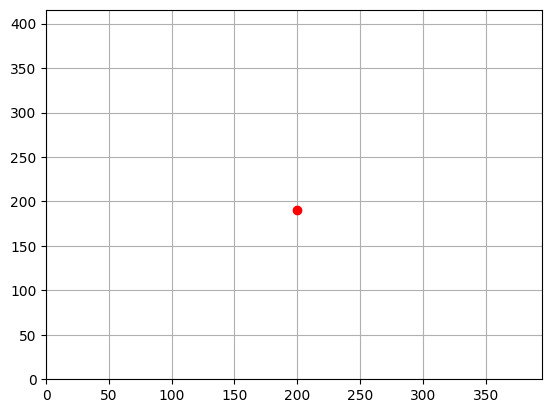

Distance:

 46.806936856962295
Distance: 43.270880824994904
Distance: 46.00662338648089
Distance: 45.27589665950114
Distance: 41.710414333780456
Distance: 41.24001601909592
Distance: 44.00522114505886
Distance: 43.45761194281733
Distance: 40.17457030543665
Distance: 39.718401415059276
Distance: 42.522088703367764
Distance: 39.30973224073741
Distance: 38.94634087476051
Distance: 60.010447289179716
Distance: 41.78282774234392
Distance: 34.18832485410908
Distance: 28.917250701126143
Distance: 41.481730341535844
Distance: 33.941959507300254
Distance: 28.73899044936413
Distance: 62.09822913919697
Distance: 33.7312323922139
Distance: 40.66325745923749
Distance: 37.91085962026084
Distance: 33.55507481365364
Distance: 28.47002004352575
Distance: 50.537957493610854
Distance: 37.61905507551441
Distance: 33.41261282563761
Distance: 40.27916427796245
Distance: 50.37239179180868
Distance: 40.701026081003256
Distance: 37.626234872118175
Distance: 60.36617637446979
Distance: 39.99003433784995
Distance: 50.25595

In [ ]:

start = starting_point
goal = goal_location
map_size = [map_size_x, map_size_y, map_size_z]
rrt_star = RRTStar(start, goal, map_size, lidar_sensor)
def animate(i):
        if i < rrt_star.max_iter and not rrt_star.goal_reached:
            rand_node = rrt_star.get_random_node()
            nearest_node = rrt_star.get_nearest_node(rrt_star.node_list, rand_node)
            new_node = rrt_star.steer(nearest_node, rand_node)
            
            if rrt_star.is_collision_free(new_node):
                neighbors = rrt_star.find_neighbors(new_node)
                new_node = rrt_star.choose_parent(neighbors, nearest_node, new_node)
                rrt_star.node_list.append(new_node)
                rrt_star.rewire(new_node, neighbors)
            
            # Check if goal is reached
            if rrt_star.reached_goal(new_node):
                rrt_star.path = rrt_star.generate_final_path(new_node)
                rrt_star.goal_reached = True
            
            # Update tree visualization
            rrt_star.draw_tree(new_node)
        
        # Draw the path if goal is reached
            if rrt_star.goal_reached:
                rrt_star.draw_path()
                aani = animation.FuncAnimation(rrt_star.fig, animate, frames=rrt_star.max_iter, interval=10, repeat=False)
                plt.show()